In [4]:
import time
import copy
from pathlib import Path

In [5]:
import numpy as np
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
from PIL import Image

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
torch.manual_seed(7)

batch_size = 256
epochs = 20
learning_rate = 1e-3
reg = 1e-7
step_size = 10
gamma = 0.5

Using device: cpu


In [13]:
transform = transforms.Compose([# Without augmentation for the moment
                transforms.Resize(256), # Resizing because ResNet uses 256x256 images
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),])

def collate_mnist(batch): #https://discuss.pytorch.org/t/how-to-use-one-class-of-number-in-mnist/26276/8
    modified_batch = []
    for item in batch:
        image, label = item
        if label == 0:
            label = 0
        
        if label == 5:
            label = 1
        
        if not(label == 5 or label==0):
            label = 2
        
        item = image, label
        modified_batch.append(item)
    
    return torch.utils.data.dataloader.default_collate(modified_batch)    

## Creating Datasets

In [14]:
mnist_path = Path('./mnist')

if not mnist_path.exists():
    mnist_path.mkdir()

mnist_trainset = datasets.MNIST(root=str(mnist_path.resolve()), train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root=str(mnist_path.resolve()), train=False, download=True, transform=transform)

print(f'Trainset size: {len(mnist_trainset)}')
print(f'Testset size: {len(mnist_testset)}')

Trainset size: 60000
Testset size: 10000


In [15]:
iterator = iter(mnist_trainset)
im,_ = next(iterator)
im.shape

torch.Size([1, 256, 256])

## Defining the data Transform

In [51]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size, shuffle=True, collate_fn=collate_mnist)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size, shuffle=True, collate_fn=collate_mnist)

class_names = ['Class 0', 'Class 5', 'Class unknown']
dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train':len(mnist_trainset), 'val':len(mnist_testset)}

In [17]:
iterator = iter(testloader)

In [18]:
im, label = next(iterator)

tensor(2)


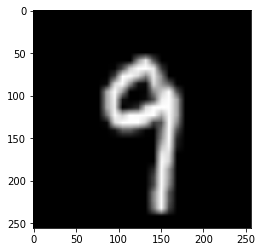

In [19]:
plt.imshow(im.cpu().detach()[10][0].numpy(), cmap='gray', interpolation='none')
print(label[10])

In [20]:
im.shape

torch.Size([256, 1, 256, 256])

# Model

In [56]:
class mnistClassifier(nn.Module):
    
    def __init__(self, device):
        super(mnistClassifier, self).__init__()
        self.network = models.resnet18(pretrained=True)

        for param in self.network.parameters():
            param.requires_grad = False

        self.network.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = self.network.fc.in_features
        model.fc = nn.Linear(num_ftrs, 3)
        self.network = self.network.to(device)

    def forward(self, x):
        return self.network(x)    

In [22]:

model = models.resnet18(pretrained=True, progress=False)

for param in model.parameters():
            param.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training

In [41]:
def checkpoint(root, epoch, model):
    """ Saves the dictionaries of a given pytorch model for 
        the right epoch
        """
    model_out_path = "model_epoch_{}.pth".format(epoch)
    model_out_path = root / model_out_path;
    torch.save(model.state_dict() , model_out_path);
    print("Checkpoint saved to {}".format(model_out_path))

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        checkpoint(Path("./checkpoints/"), epoch, model)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def load_model(path):
  pass
  #model.load_state_dict(torch.load('./checkpoints/model_epoch_1.pth', map_location=torch.device(device)))

In [ ]:
#for epoch in range(epochs):
#    running_loss = 0.0
#    for i, data in enumerate(trainloader, 0):
#        inputs, labels = data
#        inputs = inputs.to(device)
#        labels = labels.to(device)
#        
#        optimizer.zero_grad()
#         
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#     print(running_loss)
# print('Finished Training')

In [ ]:
train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.0086 Acc: 0.9975
val Loss: 0.0107 Acc: 0.9966
Checkpoint saved to checkpoints/model_epoch_0.pth

Epoch 1/19
----------
train Loss: 0.0081 Acc: 0.9975
val Loss: 0.0130 Acc: 0.9956
Checkpoint saved to checkpoints/model_epoch_1.pth

Epoch 2/19
----------
train Loss: 0.0077 Acc: 0.9977
val Loss: 0.0110 Acc: 0.9962
Checkpoint saved to checkpoints/model_epoch_2.pth

Epoch 3/19
----------
train Loss: 0.0070 Acc: 0.9980
val Loss: 0.0118 Acc: 0.9964
Checkpoint saved to checkpoints/model_epoch_3.pth

Epoch 4/19
----------
train Loss: 0.0068 Acc: 0.9979
val Loss: 0.0114 Acc: 0.9969
Checkpoint saved to checkpoints/model_epoch_4.pth

Epoch 5/19
----------
train Loss: 0.0068 Acc: 0.9980
val Loss: 0.0089 Acc: 0.9970
Checkpoint saved to checkpoints/model_epoch_5.pth

Epoch 6/19
----------
train Loss: 0.0061 Acc: 0.9980
val Loss: 0.0109 Acc: 0.9964
Checkpoint saved to checkpoints/model_epoch_6.pth

Epoch 7/19
----------
train Loss: 0.0061 Acc: 0.9982
val Loss: 0.0102

In [43]:
def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model.train(mode=was_training)

In [23]:
model.load_state_dict(torch.load('./checkpoints/model_epoch_1.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [24]:
im, label = next(iterator)
im.shape

torch.Size([256, 1, 256, 256])

In [25]:
result = model(im)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [26]:
result.shape

torch.Size([256, 3])

In [54]:
a = nn.Softmax(dim=0)
k = a(result[5])
print(class_names[k.argmax()])

Class unknown
